In [1]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import h5py

In [71]:
class dnn:
    def __init__(self, layers, activations, learning_rate, batch_size = 0):
        
        self.__layers = layers
        self.__activations = activations
        self.__lr = learning_rate
        self.__batch_size = batch_size
        self.__depth = len(layers)
        self.__params = {}
        self.__grads = {}
        
        if (batch_size == 0):
            self.__use_mini_batch = False
        else:
            self.__use_mini_batch = True
            
    def __init_params(self):
        np.random.seed(1)
        for l in range(1, self.__depth):
            self.__params["W" + str(l)] = np.random.randn(self.__layers[l], self.__layers[l-1]) / np.sqrt((self.__layers[l-1]))
            self.__params["b" + str(l)] = np.zeros((self.__layers[l], 1))    
    
    def __relu(self, Z):
        Z = self.__apply_dropout(Z, 0.8)
        A = np.maximum(0,Z)
        cache = Z
        return A, cache
            
    def __sigmoid(self, Z):    
        A = 1/(1+np.exp(-Z))
        cache = Z
        return A, cache
    
    def __apply_dropout(self, A, keep_prob):
        D = np.random.randn(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = np.multiply(A, D) + 0
        A = A / keep_prob
        return A
        
    
    def __fwd_activation(self, Z, activation):
        if(activation == 'relu'):
            A, cache = self.__relu(Z)
        elif(activation == 'sigmoid'):
            A, cache = self.__sigmoid(Z)
        return A, cache
        
        
    def __forward_prop(self, A_prev, W, b, activation):  
        linear_cache = {}
        activation_cache = {}
        Z = np.dot(W, A_prev) + b 
        A, activation_cache = self.__fwd_activation(Z, activation)
        
        linear_cache = (A_prev, W, b)
        cache = (linear_cache, activation_cache)
        
        return A, cache 
    
    def __forward_step(self, X_train):
        A_prev = X_train
        caches = []
        
        for l in range(1, self.__depth):
            A, cache = self.__forward_prop(A_prev, self.__params['W' + str(l)], self.__params['b' + str(l)], self.__activations[l])
            A_prev = A
            caches.append(cache)
    
        return A_prev, caches
    
    
    def __back_prop(self, y, caches, AL):
        dAL = -(np.divide(y, AL)  - np.divide((1-y), (1-AL)))
        L = len(caches)
        
        current_cache = caches[L - 1]        
        self.__grads['dA' + str(L-1)], self.__grads['dW' + str(L)], self.__grads['db' + str(L)]  = self.__linear_activation_back(dAL, current_cache, self.__activations[L])    
        
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            self.__grads['dA' + str(l)], self.__grads['dW' + str(l+1)], self.__grads['db' + str(l+1)]  = self.__linear_activation_back(self.__grads['dA' + str(l+1)], current_cache, self.__activations[l+1])
    
    
    def __d_sigmoid(self,dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        return dZ
    
    def __d_relu(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy = True)
        
        dZ[Z <= 0] = 0
        assert (dZ.shape == Z.shape)
    
        return dZ


    def __linear_activation_back(self, dA, cache, activation):
        if activation == 'relu':
            dZ = self.__d_relu(dA, cache[1])
        elif activation == 'sigmoid':
            dZ = self.__d_sigmoid(dA, cache[1])    
    
        dA_prev, dW, db = self.__linear_back(dZ, cache[0])
    
        return dA_prev, dW, db

    def __linear_back(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]
    
        dA_prev = np.dot(W.T, dZ) 
        dW = 1/m * np.dot(dZ, A_prev.T)
        db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    
        return dA_prev, dW, db
        
    
    def describe(self):
        for i in range(self.__depth):
            if(i == 0):
                type = 'Input'
            elif(i == self.__depth - 1):
                type = 'Output'
            else:
                type = 'Hidden'
            
            print('Layer ' + str(i+1) + ' ==> Activation: ' + str(self.__activations[i]) + ', Nodes: ' + str(self.__layers[i]) + ', Type: ' + str(type))        

    def __calc_cost(self, A, y):
        m = y.shape[1]
        cost = -(1/m) * np.sum(np.dot(y, np.log(A).T) + np.dot((1-y), np.log(1-A).T))

        return cost         
            
    def __update_params(self):
        for l in range(1, self.__depth):
            self.__params['W' + str(l)] = self.__params['W' + str(l)] - self.__lr * self.__grads['dW' + str(l)]
            self.__params['b' + str(l)] = self.__params['b' + str(l)] - self.__lr * self.__grads['db' + str(l)]
            
            
    def train_network(self, X_train, y_train, num_iterations):    
        print("Initializing Training")
        self.__init_params()
        for i in range(num_iterations):
            AL, caches = self.__forward_step(X_train)
            
            cost = self.__calc_cost(AL, y_train)

            self.__back_prop(y_train, caches, AL)
        
            self.__update_params()
            
            if(i % 500 == 0):
                print(cost)
        
        
        return None
    
    def predict(self, x_test):
        A, cache = self.__forward_step(x_test)
    
        predictions = (A >= 0.5).astype(int)
    
        return predictions
            
    def print_accuracy(self, predictions, y_test):
        x = (np.abs(predictions - y_test)).sum()
        acc = 100 - ((x/y_test.shape[1]) * 100)
        
        return str(acc) + "%"
            
        

In [72]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    y = y.reshape(y.shape[1])
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

In [73]:
dataset = make_moons(n_samples = 5000, noise=0.1, random_state=0)
# dataset = make_circles(n_samples = 2000, shuffle=True, noise=0.01, random_state=0, factor=0.8)

X = dataset[0]
Y = dataset[1]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.3)

y_test = y_test.reshape(1, y_test.shape[0])
y_train = y_train.reshape(1, y_train.shape[0])

X_train = X_train.T
X_test = X_test.T

In [74]:
X_train.shape

(2, 3500)

In [75]:
y_train.shape

(1, 3500)

In [76]:
layers = [X_train.shape[0], 15, 12, 12, 1]
activations = ['none', 'relu', 'relu', 'relu', 'sigmoid']

In [77]:
layers

[2, 15, 12, 12, 1]

In [78]:
activations

['none', 'relu', 'relu', 'relu', 'sigmoid']

In [79]:
nn1 = dnn(layers, activations, 0.7, 64)

In [80]:
nn1.describe()

Layer 1 ==> Activation: none, Nodes: 2, Type: Input
Layer 2 ==> Activation: relu, Nodes: 15, Type: Hidden
Layer 3 ==> Activation: relu, Nodes: 12, Type: Hidden
Layer 4 ==> Activation: relu, Nodes: 12, Type: Hidden
Layer 5 ==> Activation: sigmoid, Nodes: 1, Type: Output


In [85]:
nn1.train_network(X_train, y_train, 1000)

Initializing Training
0.9173562569673129


/home/taimur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: divide by zero encountered in log
/home/taimur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
/home/taimur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less_equal


nan


In [134]:
predictions = nn1.predict(X_test)

In [135]:
nn1.accuracy(predictions, y_test)

'99.8%'

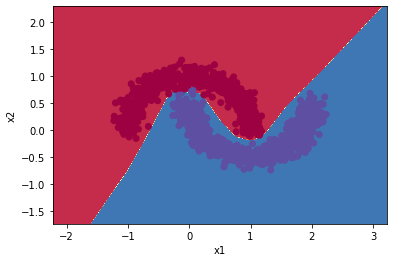

In [136]:
plot_decision_boundary(lambda x: nn1.predict(x.T), X_test, y_test)

In [105]:
file_name = 'train_catvnoncat.h5'

In [106]:
with h5py.File(file_name, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    b_group_key = list(f.keys())[1]
    c_group_key = list(f.keys())[2]
    a_group_key = list(f.keys())[0]

    # Get the data
    x_train = list(f[b_group_key])
    y_train = list(f[c_group_key])
    labels = list(f[a_group_key])

Keys: <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [107]:
X_train  = np.array(x_train)
Y_train  = np.array(y_train)

In [108]:
X_train = X_train.reshape((X_train.shape[0], -1)).T
Y_train = Y_train.reshape((Y_train.shape[0],1)).T

In [109]:
X_train = X_train / 255
Y_train = Y_train

In [110]:
file_name = 'test_catvnoncat.h5'


In [111]:
with h5py.File(file_name, 'r') as f:
    # List all groups
    print("Keys: %s" % f.keys())
    b_group_key = list(f.keys())[1]
    c_group_key = list(f.keys())[2]
    a_group_key = list(f.keys())[0]

    # Get the data
    x_test = list(f[b_group_key])
    y_test = list(f[c_group_key])
    labels_test = list(f[a_group_key])

Keys: <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>


In [112]:
X_test = np.array(x_test)
Y_test = np.array(y_test)

In [113]:
X_test = X_test.reshape((X_test.shape[0], -1)).T
Y_test = Y_test.reshape((Y_test.shape[0],1)).T

In [114]:
X_test = X_test / 255
Y_test = Y_test

In [115]:
layers = [X_train.shape[0], 20, 7 ,5, 1]
activations = ['input', 'relu','relu', 'relu', 'sigmoid']

In [116]:
nn1 = dnn(layers, activations, 0.009, 64)

In [117]:
nn1.describe()

Layer 1 ==> Activation: input, Nodes: 12288, Type: Input
Layer 2 ==> Activation: relu, Nodes: 20, Type: Hidden
Layer 3 ==> Activation: relu, Nodes: 7, Type: Hidden
Layer 4 ==> Activation: relu, Nodes: 5, Type: Hidden
Layer 5 ==> Activation: sigmoid, Nodes: 1, Type: Output


In [118]:
nn1.train_network(X_train, Y_train, 2500)

Initializing Training
1.2081250106003227
0.6467047774694484
0.6441213739638008
0.6439815775770755
0.6439741524434397


In [119]:
predictions = nn1.predict(X_test)

In [120]:
nn1.accuracy(predictions, Y_test)

'34.0%'

In [121]:
predictions

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

In [122]:
Y_test

array([[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 0]])

In [89]:
Z = np.random.randn(3,3)

In [90]:
D = np.random.randn(3, 3)
D = (D < 0.7)
# Z = np.multiply(Z, D)
# Z = Z/keep_prob
   

In [1591]:
D

array([[ True,  True,  True],
       [ True, False,  True],
       [False, False,  True]])

In [1592]:
Z

array([[ 1.35426922, -0.04410415,  0.69274349],
       [-0.54776281, -0.23763207, -0.87245506],
       [-0.05849467,  0.43358628,  0.14118822]])

In [1593]:
Z = np.multiply(Z, D) + 0

In [1594]:
Z

array([[ 1.35426922, -0.04410415,  0.69274349],
       [-0.54776281,  0.        , -0.87245506],
       [ 0.        ,  0.        ,  0.14118822]])

In [1559]:
Z = Z / 0.7

In [1560]:
Z

array([[ 1.90181093,  2.99659619,  0.        ],
       [-2.39419515,  1.14830424, -0.33574501],
       [ 2.33643954, -0.31044426,  1.69344703]])

In [34]:

    def apply_dropout(A, keep_prob):
        D = np.random.randn(A.shape[0], A.shape[1])
        print(D)
        D = (D < keep_prob).astype(int)
        A = np.multiply(A, D) + 0
        A = A / keep_prob
        return A